Exercise 10.

Style Transfer tutorial  
https://www.tensorflow.org/tutorials/generative/style_transfer

In [1]:
import time
import numpy as np
import PIL.Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython.display as display
import tensorflow as tf
from tensorflow import keras

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [2]:
def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

In [3]:
content_path = keras.utils.get_file('YellowLabradorLooking_new.jpg', 
                                    'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

style_path = keras.utils.get_file('kandinsky5.jpg',
                                  'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [5]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
        
    plt.imshow(image)
    if title:
        plt.title(title)

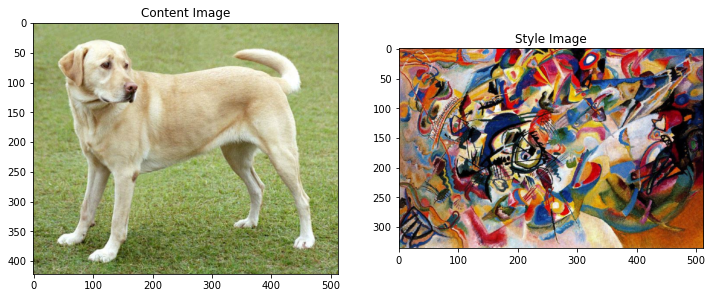

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

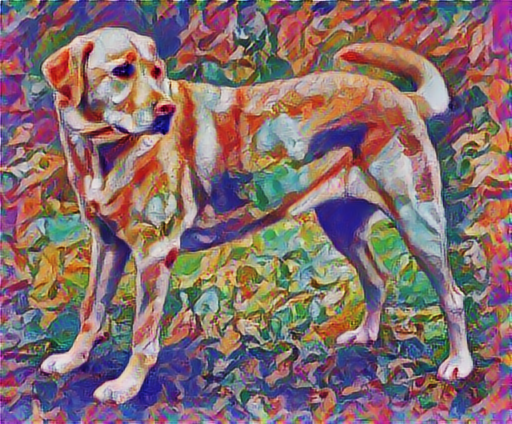

In [7]:
import tensorflow_hub as hub

hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [8]:
x = keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [9]:
predicted_top_5 = keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

[('Labrador_retriever', 0.4931709),
 ('golden_retriever', 0.23665284),
 ('kuvasz', 0.03635757),
 ('Chesapeake_Bay_retriever', 0.02418276),
 ('Greater_Swiss_Mountain_dog', 0.018646095)]

In [10]:
vgg = keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
    print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [11]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def vgg_layers(layer_names):
    vgg = keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extactor = vgg_layers(style_layers)
style_outputs = style_extactor(style_image * 255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(f'\tshape: {output.numpy().shape}')
    print(f'\tmin: {output.numpy().min()}')
    print(f'\tmax: {output.numpy().max()}')
    print(f'\tmean: {output.numpy().mean()}')
    print()

block1_conv1
	shape: (1, 336, 512, 64)
	min: 0.0
	max: 835.5255737304688
	mean: 33.975250244140625

block2_conv1
	shape: (1, 168, 256, 128)
	min: 0.0
	max: 4625.8857421875
	mean: 199.82687377929688

block3_conv1
	shape: (1, 84, 128, 256)
	min: 0.0
	max: 8789.2392578125
	mean: 230.78099060058594

block4_conv1
	shape: (1, 42, 64, 512)
	min: 0.0
	max: 21566.134765625
	mean: 791.2400512695312

block5_conv1
	shape: (1, 21, 32, 512)
	min: 0.0
	max: 3189.254150390625
	mean: 59.17947769165039



In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [15]:
class StyleContentModel(keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) 
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

result = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(result['style'].items()):
    print(f'\t{name}')
    print(f'\t\tshape: {output.numpy().shape}')
    print(f'\t\tmin: {output.numpy().min()}')
    print(f'\t\tmax: {output.numpy().max()}')
    print(f'\t\tmean: {output.numpy().mean()}')
    print()
    
print('Contents:')
for name, output in sorted(result['content'].items()):
    print(f'\t{name}')
    print(f'\t\tshape: {output.numpy().shape}')
    print(f'\t\tmin: {output.numpy().min()}')
    print(f'\t\tmax: {output.numpy().max()}')
    print(f'\t\tmean: {output.numpy().mean()}')
    print()

Styles:
	block1_conv1
		shape: (1, 64, 64)
		min: 0.005522845312952995
		max: 28014.521484375
		mean: 263.7901916503906

	block2_conv1
		shape: (1, 128, 128)
		min: 0.0
		max: 61479.484375
		mean: 9100.94921875

	block3_conv1
		shape: (1, 256, 256)
		min: 0.0
		max: 545623.4375
		mean: 7660.97607421875

	block4_conv1
		shape: (1, 512, 512)
		min: 0.0
		max: 4320501.0
		mean: 134288.84375

	block5_conv1
		shape: (1, 512, 512)
		min: 0.0
		max: 110005.34375
		mean: 1487.0380859375

Contents:
	block5_conv2
		shape: (1, 26, 32, 512)
		min: 0.0
		max: 2410.879638671875
		mean: 13.764148712158203



In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
image = tf.Variable(content_image)

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [21]:
style_weight=1e-2
content_weight=1e4

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name]) ** 2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name]) ** 2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [23]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

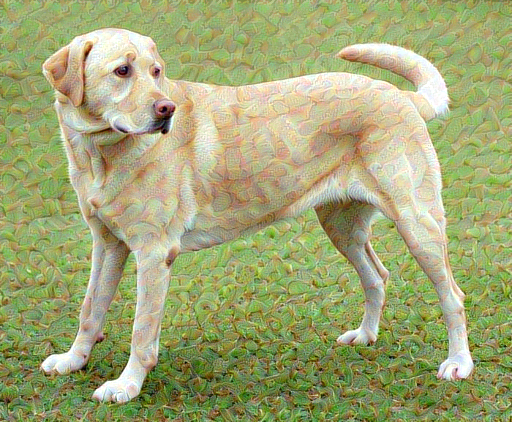

In [24]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

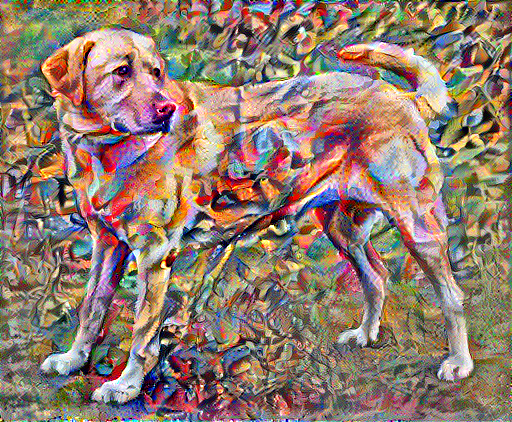

Train step: 1000
Total time: 103.5


In [25]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f'Train step: {step}')

end = time.time()
print(f'Total time: {end-start:.1f}')

In [26]:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

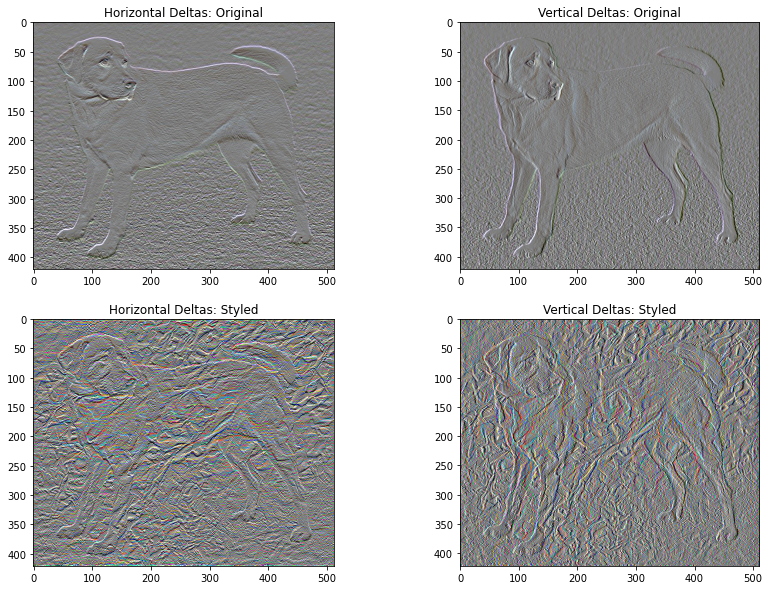

In [27]:
x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2 * y_deltas + 0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2 * x_deltas + 0.5), "Vertical Deltas: Styled")

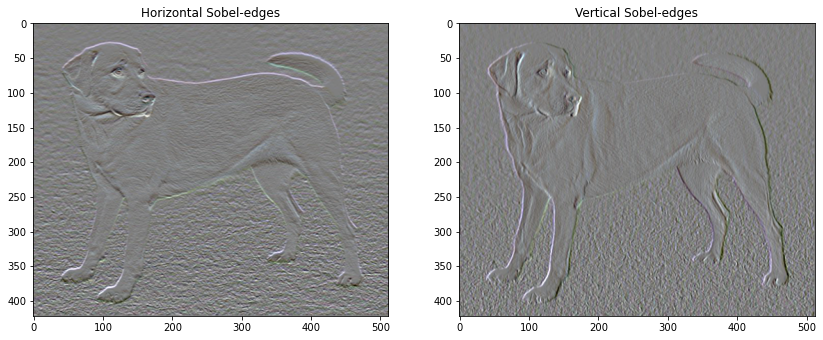

In [28]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[...,0] / 4 + 0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[...,1] / 4 + 0.5), "Vertical Sobel-edges")

In [29]:
def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [30]:
total_variation_loss(image).numpy()

149388.27

In [31]:
tf.image.total_variation(image).numpy()

array([149388.27], dtype=float32)

In [32]:
total_variation_weight=30

In [33]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight * tf.image.total_variation(image)
        
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [34]:
image = tf.Variable(content_image)

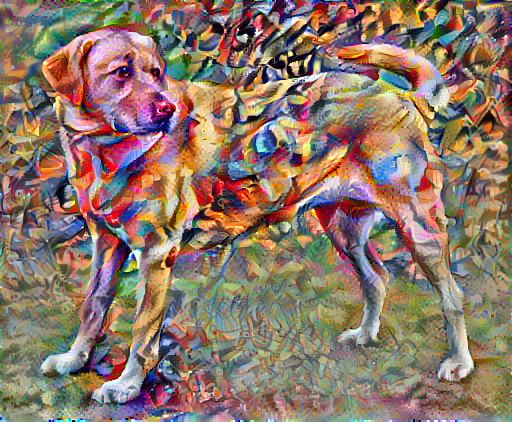

Train step: 1000
Total time: 101.9


In [35]:
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print(f'Train step: {step}')

end = time.time()
print(f'Total time: {end-start:.1f}')

In [36]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)